<a href="https://colab.research.google.com/github/ellagattis/kuka/blob/main/statistical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##initial imports

In [ ]:
#pip installs i need
!pip install control
!pip install pandas
!pip install ipympl

     |████████████████████████████████| 348kB 5.3MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=9332d11ff53e13e08f57c4a92ebff534073b5ec3781b30dbbf09c673089467d2
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control
     |████████████████████████████████| 112kB 5.4MB/s 


In [ ]:
#imports needed
import pickle
import numpy as np
import matplotlib.pyplot as plt
import control
import math
import fnmatch
import os
import random
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial import distance
from scipy.signal import argrelextrema, argrelmax, argrelmin
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from rosie's code
class kuka_magna: 

    def __init__(self, date, bandwidth, binsize):  #e.g. 20191107
        self.date = date
   
    def rfiles(self): #radar data files
       
        print('running rfiles')
        print('date: ', date)
        print('bandwidth: ', bandwidth)


       
        if bandwidth == 'full_bw':
            print('bandwidth is full_bw')
            file_path = '/content/drive/My Drive/msci_project/'
        elif bandwidth == 'cs2_alt':
            print('bandwidth is cs2_alt')
            file_path = '/content/drive/My Drive/msci_project/'
       
        print('file path: ',file_path)



#get the ship location info and correct the lat and lons
#     def sfiles(self):
        pfile_path = '/content/drive/My Drive/msci_project/'

        pos = pd.read_csv(pfile_path+'data', sep='\t',skipinitialspace=True,skiprows=1,engine='python')
        pos = pd.DataFrame(pos).to_numpy()

        ship_lat = pos[:,1]
        ship_lon = pos[:,2]
        ship_heading = pos[:,3]

        t=pos[:,0]

        year = [int(sub[0:4]) for sub in t]
        month = [int(sub[5:7]) for sub in t]
        day = [int(sub[8:10]) for sub in pos[:,0]]
        hour = [int(sub[11:13]) for sub in pos[:,0]]
        minute = [int(sub[14:16]) for sub in pos[:,0]]
        second = [int(sub[17:19]) for sub in pos[:,0]]

#         ship_dt=np.zeros(len(year))
        ship_dt=np.full(len(year), np.nan)

        for i in range(len(year)):
            t=datetime.datetime(year[i],month[i],day[i],hour[i],minute[i],second[i])
            ship_dt[i] = (t - datetime.datetime(1970,1,1)).total_seconds()

        print('ship times between:')  
        print(datetime.datetime.utcfromtimestamp(ship_dt[0]))
        print(datetime.datetime.utcfromtimestamp(ship_dt[-1]))

        #correct all data to 12 midday on the day of the observations
        ref_time = datetime.datetime(int(self.date[0:4]),int(self.date[4:6]),int(self.date[6:8]),12,0,0)

        ref = np.where(ship_dt == (ref_time - datetime.datetime(1970,1,1)).total_seconds())[0]
        print('ref',ref,ref_time)
   
   
#find radar files      

        for b in ['Ka','Ku']:
            rf = fnmatch.filter(os.listdir(file_path),b+'*'+self.date+'*'+'range_hh_vv_hv_vh.txt')    #echo files
            rf.sort()                                                               #sort for echoes list
            echo_files = rf
#             print('echo_files',echo_files)
            sf = [sub[0:23]+'.nrcs.stare' for sub in rf]                            #summary files
            igroup = [sub[31:37] for sub in rf]
            elev = [sub[46:52] for sub in rf]
           
            if b == 'Ka':
                self.ka_echo_files = np.array(rf)
                self.ka_summ_files = np.array(sf)
                self.ka_igroup = np.array(igroup)
                self.ka_elev = np.array(elev)
            elif b == 'Ku':
                self.ku_echo_files = np.array(rf)
                self.ku_summ_files = np.array(sf)
                self.ku_igroup = np.array(igroup)
                self.ku_elev = np.array(elev)    
                       
#read in the echo files
       
            for r in rf:              
                print('echo file: ', r)
                ef=pd.read_csv(file_path+r, delimiter=' ',
                                    names=['range','hh','vv','hv','vh'],skipinitialspace=True)
   
                if r == rf[0]:                                             #first one
                    print('first echo')
                    echo = pd.DataFrame(ef).to_numpy()
                else:
                    print('echo', r)
                    echo = np.vstack((echo,pd.DataFrame(ef).to_numpy()))   #stack the rest
            help(echo)            
            if b == 'Ka':    
                nsamp = 4096
                self.ka_rg=echo[:,0].reshape(len(rf),nsamp).transpose()    #make 'images' from echoes
                self.ka_hh=echo[:,1].reshape(len(rf),nsamp).transpose()    #each echo is in [:,echo_number]
                self.ka_vv=echo[:,2].reshape(len(rf),nsamp).transpose()
                self.ka_hv=echo[:,3].reshape(len(rf),nsamp).transpose()
                self.ka_vh=echo[:,4].reshape(len(rf),nsamp).transpose()
            elif b == 'Ku':
                nsamp = 2048
                self.ku_rg=echo[:,0].reshape(len(rf),nsamp).transpose()
                self.ku_hh=echo[:,1].reshape(len(rf),nsamp).transpose()
                self.ku_vv=echo[:,2].reshape(len(rf),nsamp).transpose()
                self.ku_hv=echo[:,3].reshape(len(rf),nsamp).transpose()
                self.ku_vh=echo[:,4].reshape(len(rf),nsamp).transpose()    
               
#echo files done
 
#get data from summary files

            summ = []    
            peak = np.zeros(len(rf))
            lat = np.zeros(len(rf)) ; lon = np.zeros(len(rf)) ;
            start_time = np.zeros(len(rf))
            end_time = np.zeros(len(rf)) ; st = 0 ; fin = 0
           
           
       
            for s in list(dict.fromkeys(sf)) :                                        # read in summary files
                print('s',s)      
                with open(file_path+s,'r') as summfile: summ = summfile.read().splitlines()
               
                separator = ''
                ngroups = int(summ[1])
                match = [np.array(sf) == s]
                               
                st = summ.index('range peak signal: ') + 1 #data start on next line
                fin = st + summ[st:].index('')
                peak[match] = np.fromstring(separator.join(summ[st:fin]), dtype = np.float, sep = '      ' )                  

                asumm=np.array(summ)

                lat[match] = asumm[np.where(asumm == 'mean latitude: ')[0]+1]
                lon[match] = asumm[np.where(asumm == 'mean longitude: ')[0]+1]
                start_time[match] = asumm[np.where(asumm == 'start time of group: ')[0]+1]
                end_time[match] = asumm[np.where(asumm == 'end time of group: ')[0]+1]

                if b == 'Ka':
                    self.ka_peak = peak
                    self.ka_lat = lat
                    self.ka_lon = lon      
                    self.ka_start_time = start_time
                    self.ka_end_time = end_time
                elif b == 'Ku':
                    self.ku_peak = peak
                    self.ku_lat = lat
                    self.ku_lon = lon      
                    self.ku_start_time = start_time
                    self.ku_end_time = end_time
                   
#location correction using ship data
 
       
        #ka
        ka_lat_n = np.zeros(len(self.ka_start_time))
        ka_lon_n = np.zeros(len(self.ka_start_time))
        for i in range(len(self.ka_start_time)):
            before = np.where(ship_dt <= self.ka_start_time[i])
            before = before[-1]
            before = before[-1]
            after = np.where(ship_dt >= self.ka_start_time[i])
            after = after[0]
            after = after[0]
            prop = (self.ka_start_time[i] - ship_dt[before])/(ship_dt[after] - ship_dt[before])
            shift_lat = (ship_lat[after]-ship_lat[before])*prop + (ship_lat[before] - ship_lat[ref])
            ka_lat_n[i] = self.ka_lat[i] - shift_lat    
            shift_lon = (ship_lon[after]-ship_lon[before])*prop + (ship_lon[before] - ship_lon[ref])
            ka_lon_n[i] = self.ka_lon[i] - shift_lon  
        self.ka_lat_n = ka_lat_n
        self.ka_lon_n = ka_lon_n
       
        #ku
        ku_lat_n = np.zeros(len(self.ku_start_time))
        ku_lon_n = np.zeros(len(self.ku_start_time))
        for i in range(len(self.ku_start_time)):
            before = np.where(ship_dt <= self.ku_start_time[i])
            before = before[-1]
            before = before[-1]
            after = np.where(ship_dt >= self.ku_start_time[i])
            after = after[0]
            after = after[0]
            prop = (self.ku_start_time[i] - ship_dt[before])/(ship_dt[after] - ship_dt[before])
            shift_lat = (ship_lat[after]-ship_lat[before])*prop + (ship_lat[before] - ship_lat[ref])
            ku_lat_n[i] = self.ku_lat[i] - shift_lat    
            shift_lon = (ship_lon[after]-ship_lon[before])*prop + (ship_lon[before] - ship_lon[ref])
            ku_lon_n[i] = self.ku_lon[i] - shift_lon  

        self.ku_lat_n = ku_lat_n
        self.ku_lon_n = ku_lon_n

In [ ]:
#load the object
date = '20200116'
bandwidth = 'full_bw'
save_folder = '/content/drive/My Drive/msci_project/'
file = date+'_'+bandwidth+'.p'
test = pickle.load(open(save_folder+file, "rb"))  
print(dir(test))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'date', 'ka_echo_files', 'ka_elev', 'ka_end_time', 'ka_hh', 'ka_hv', 'ka_igroup', 'ka_lat', 'ka_lat_n', 'ka_lon', 'ka_lon_n', 'ka_peak', 'ka_rg', 'ka_start_time', 'ka_summ_files', 'ka_vh', 'ka_vv', 'ku_echo_files', 'ku_elev', 'ku_end_time', 'ku_hh', 'ku_hv', 'ku_igroup', 'ku_lat', 'ku_lat_n', 'ku_lon', 'ku_lon_n', 'ku_peak', 'ku_rg', 'ku_start_time', 'ku_summ_files', 'ku_vh', 'ku_vv', 'rfiles']


In [ ]:
#load metal plate data
file_path = '/content/drive/My Drive/msci_project/metal_plate/Ka-Scat-20200107-134243_igroup_000000_line_el_000000_range_hh_vv_hv_vh.txt'
import pandas as pd
r = 'Ka-Scat-20200107-134243_igroup_000000_line_el_000000_range_hh_vv_hv_vh'
r2 = 'Ku-Scat-20200107-140435_igroup_000000_line_el_000000_range_hh_vv_hv_vh'
file_path_2 = '/content/drive/My Drive/msci_project/metal_plate/Ku-Scat-20200107-140435_igroup_000000_line_el_000000_range_hh_vv_hv_vh.txt'
s2 = 'Ku-Scat-20200107-134243_igroup_000000_line_el_000000_range_hh_vv_hv_vh.txt'
e = pd.read_csv(file_path_2, delimiter=' ', names=['range','hh','vv','hv','vh'], skipinitialspace=True)

In [ ]:
#load magnaprobe data
mfile_path = '/content/drive/My Drive/msci_project/magna_xy/'
mf = fnmatch.filter(os.listdir(mfile_path),'*'+date+'*')
print('mf',mf)
mf = mf[0]
print('mf',mf)
mag = pd.read_csv(mfile_path+mf)

mf ['PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanS-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanN-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33-20200116-UTC-0.csv']
mf PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv


['ka_20200116.csv', 'ku_20200116.csv']


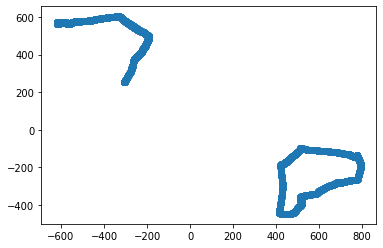

In [ ]:
#load kuka locations
klfile_path = '/content/drive/My Drive/msci_project/kuka_locations/'
klf = fnmatch.filter(os.listdir(klfile_path),'*'+date+'*'+ '.csv')
print(klf)
ka_loc = klf[0]
ku_loc = klf[1]
ka_loc = pd.read_csv(klfile_path+ka_loc)
ku_loc = pd.read_csv(klfile_path+ku_loc)
plt.plot(ku_loc.x, ku_loc.y, 'o')

##nearest neighbour search

In [ ]:
#use scipy's cdist function to find closest magnaprobe point for each ku point
def closest_point(point, magna_points):
    magna_locations = (magna_points.xc, magna_points.yc)
    magna_locations = (np.transpose(magna_locations))
    closest_index = distance.cdist([point], magna_locations).argmin()
    #result = np.count_nonzero(dist_matrix<=r)
    return magna_points.iloc[closest_index]

ku_closest_points_list = []

for i in range(len(ku_loc)):
  mag_cp = closest_point(ku_loc.iloc[i], mag)
  ku_closest_points_list.append(mag_cp)

#cp_array = np.vstack(closest_points_list)

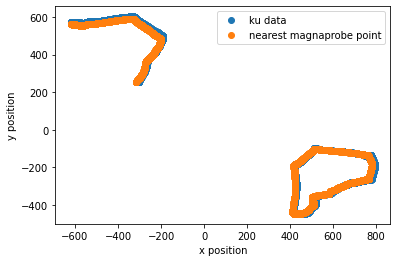

In [ ]:
ku_ordered_df = pd.concat(ku_closest_points_list)
plt.plot(ku_loc.x, ku_loc.y, 'o', label='ku data')
plt.plot(ku_ordered_df.xc, ku_ordered_df.yc, 'o', label = 'nearest magnaprobe point')
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()

In [ ]:
#use scipy's cdist function to find closest magnaprobe point for each ka point
def closest_point(point, magna_points):
    magna_locations = (magna_points.xc, magna_points.yc)
    magna_locations = (np.transpose(magna_locations))
    closest_index = distance.cdist([point], magna_locations).argmin()
    #result = np.count_nonzero(dist_matrix<=r)
    return magna_points.iloc[closest_index]

ka_closest_points_list = []

for i in range(len(ka_loc)):
  mag_cp = closest_point(ka_loc.iloc[i], mag)
  ka_closest_points_list.append(mag_cp)

ka_ordered_df = pd.concat(ka_closest_points_list)

In [ ]:
#from scipy.spatial import KDTree
#tree = KDTree(ku_loc)
#results = tree.query_ball_point(np.transpose(mag.xc, mag.yc), r=10)

# mask repeated echoes


In [ ]:
#Calculate Ku mask 

print((test.ku_vv).shape)
temp=(test.ku_vv)
temp1=np.roll(temp,shift=1,axis=1)
print(temp.shape)
print(temp1.shape)
diff=temp1-temp
std=[]
for i in range ((test.ku_vv).shape[1]):
    std.append(np.sum(diff[:,i]**2))

    
mask_ku=np.outer(np.ones((2048)), np.asarray(std))
print(mask_ku.shape)
mask_ku[mask_ku<10000]=np.nan
mask_ku[mask_ku>=10000]=1.

# np.diff finds difference between consecutive elements 
d = np.sqrt( np.diff(ku_loc.x)**2 + np.diff(ku_loc.y)**2 )
#d = np.append(d) # add item to end because d has one less element
ku_mask = np.where((d > 0.1))[0]

(2048, 7212)
(2048, 7212)
(2048, 7212)
(2048, 7212)


In [ ]:
#Calculate Ka mask 
print((test.ka_vv).shape)
temp=(test.ka_vv)
temp1=np.roll(temp,shift=1,axis=1)
print(temp.shape)
print(temp1.shape)
diff=temp1-temp
std=[]
for i in range ((test.ka_vv).shape[1]):
    std.append(np.sum(diff[:,i]**2))
  
mask=np.outer(np.ones((4096)), np.asarray(std))
    
mask[mask<20000]=np.nan
mask[mask>=20000]=1.
# mask[:,1300] 


# np.diff finds difference between consecutive elements 
d = np.sqrt( np.diff(ka_loc.x)**2 + np.diff(ka_loc.y)**2 )
#d = np.append(d, 1) # add item to end because d has one less element
ka_mask = np.where((d > 0.1))[0]

(4096, 10980)
(4096, 10980)
(4096, 10980)


## methods to evaluate how well the radar data matches magnaprobe data
* magnaprobe snow depth vs radar maximum/first maximum/second maximum?
* could compare these initially with something simple like a $\chi^2$ evaluation
* does the width of the power spectrum affect how well it fits?
- come up with statistical comparisons between the KaKu metrics (vars) and the magnaprobe snow depth (hs)
- compare the locations of the KaKu peaks with the snow depth hs
- present some preliminary results of vars vs hs (or combination of vars in a prototype regresssion model)
- think about ways to pre-process the hs and vars so that the training can be more efficient
- plot the results along a curvilinear coordinate (i.e. following the distance travelled) 

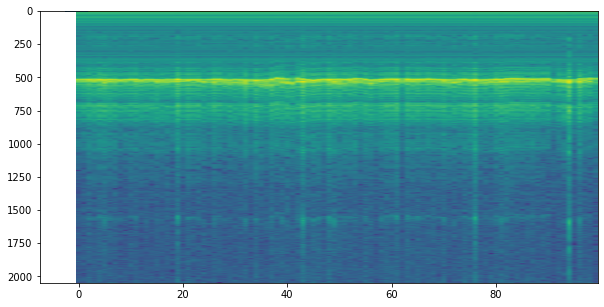

In [ ]:
sliced_array = test.ku_hh[:,4200:4300]
maxpoints = np.amax(sliced_array, axis=0)
maxdepths = np.asarray(test.ku_rg[np.where(sliced_array == np.amax(sliced_array, axis=0))]).astype(np.float64)
snowdepths = np.asarray(maxpoints + ku_ordered_df.DepthCm.iloc[4200:4300]/100).astype(np.float64)
#print(maxdepths, "\n", snowdepths)
fig, ax = plt.subplots(figsize = (10,5))
#plt.yscale("log") #changed to plt from ax because yscale doesn't work otherwise?
ax.imshow(np.log10(sliced_array), aspect= 'auto')
#ax.xlabel('echo number')
#ax.ylabel('log_10(depth)')
#cbar = plt.colorbar() 
#cbar.set_label('intensity',size=10)
ax.plot((maxdepths), (snowdepths))

In [ ]:
#identify maxima within the echo
def find_maxima(echo,ranges):
    maxima_array = []
    ranges_array = []
    #skips first and last point because they do not have points on either side
    for i in range(1, (len(echo) - 1)):
        #only look for maxima within this depth range
        if (1.5<ranges[i]<2.5):
            if (echo[i]>echo[i-1] and echo[i]>echo[i+1]):
                maxima_array.append(echo[i])
                ranges_array.append(ranges[i])
    return maxima_array, ranges_array    

maxpoints,rangevals=find_maxima(test.ka_hh[:,0],test.ka_rg[:,0])

In [ ]:
#characterising the width of power spread
def power_width(echo,ranges):
    start_point = (0, 0)
    end_point = (0, 0)
    for i in range(1, (len(echo) - 1)):
        #first point that passes threshold
        if (echo[i]>(1.5e-05) and echo[i-1]<(1.5e-05)):
            start_point = (echo[i], ranges[i])
            break
    for i in range(1, (len(echo) - 1)):      
        #first point to fall below threshold
        if (echo[i]<(1.5e-05) and echo[i-1]>(1.5e-05)):
            end_point = (echo[i], ranges[i])
    return start_point, end_point

start, end = power_width(test.ka_hh[:,0],test.ka_rg[:,0])
print(start, end)

(2.1563849e-05, -1.9647144) (1.4472456e-05, 2.1414258)


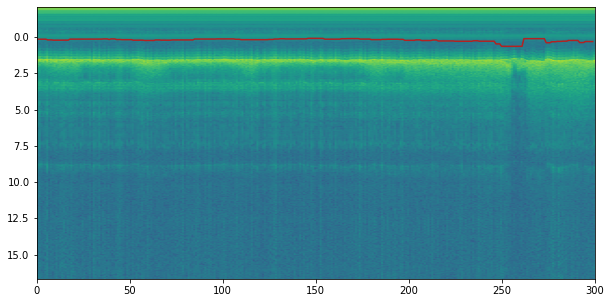

In [ ]:
sliced_array = test.ka_hh[:,2000:2300]
val = control.db2mag(37) #threshold value 37dB
airsnowval = np.argmax(sliced_array[200:,:]>val, axis=0) #skip the first 200 values

#maxdepths = np.asarray(test.ku_rg[np.where(sliced_array == np.amax(sliced_array, axis=0))]).astype(np.float64)

                        #ka derived air/snow location + magnaprobe depth converted to m (/100) / 0.8
magna_depths = np.asarray(airsnowval + ka_ordered_df.DepthCm.iloc[2000:2300]/80).astype(np.float64)

maxrg, minrg = np.amax(test.ka_rg), (np.amin(test.ka_rg))

fig, ax = plt.subplots(figsize = (10,5))
ax.imshow(control.mag2db(sliced_array), aspect= 'auto', extent=[0, 300, maxrg, minrg])
ax.plot(np.arange(0,300, 1), (magna_depths), '-', color = 'firebrick')

(4.0, 0.0)

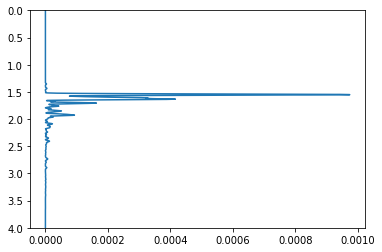

In [ ]:
plt.plot(test.ka_hh[200:,5], test.ka_rg[200:,5])
plt.ylim(4,0)

See that there is a massive peak around -2.5 which we do not want, so Ideally search array from 0 to about 4m depth. For now I have done this by slicing to ignore the first 200 elements.

pearson correlation:  0.2822468474646563


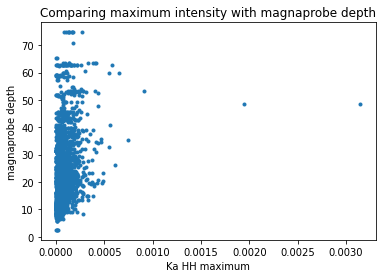

In [ ]:
a = np.asarray(np.amax(test.ku_vh[200:,ku_mask], axis=0)).astype('float64')
b = np.asarray(ku_ordered_df.DepthCm)[ku_mask].astype('float64')
plt.plot(a, b, '.')
plt.xlabel("Ka HH maximum")
plt.ylabel("magnaprobe depth")
plt.title("Comparing maximum intensity with magnaprobe depth")
print('pearson correlation: ', np.corrcoef(a, b)[0, 1])

In [ ]:
#commented out because it is really slow to run, takes all my RAM and produces almost same plot as code below

#plt.plot(test.ka_rg[np.argmax(test.ka_hh[200:,:], axis=0),:], ka_ordered_df.DepthCm, '.')
#plt.xlabel("Ka HH maximum")
#plt.ylabel("magnaprobe depth")
#plt.title("Comparing depth where echo intensity is maximum with magnaprobe depth")

pearson correlation:  0.3343715557073734


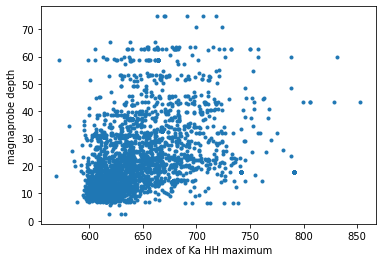

In [ ]:
a = np.asarray(np.argmax(test.ka_hv[200:,ka_mask], axis=0)).astype('float64')
b = np.asarray(ka_ordered_df.DepthCm)[ka_mask].astype('float64')

plt.plot(a,b, '.')
plt.xlabel("index of Ka HH maximum")
plt.ylabel("magnaprobe depth")
#plt.title("Comparing index at which maximum intensity occurs with magnaprobe depth")
np.shape(ka_ordered_df.DepthCm)
np.shape(test.ka_hh)
print('pearson correlation: ', np.corrcoef(a, b)[0, 1])

pearson correlation:  -0.28509388638121425


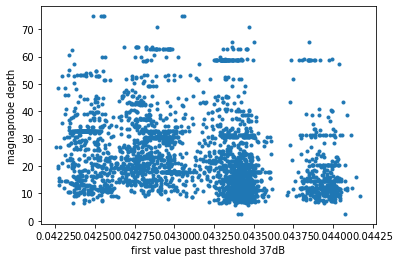

In [ ]:
res_list = []
for index in range(0, np.shape(test.ka_hh)[1]):
  res = next(x for x, mag in enumerate(test.ka_hh[200:,index]) if mag > (-val))
  element = test.ka_hh[res,index]
  res_list.append(element)
a = np.asarray(res_list, dtype='float64')
b = np.asarray(ka_ordered_df.DepthCm, dtype='float64')
plt.plot(a[ka_mask], b[ka_mask], '.')
plt.xlabel("first value past threshold 37dB")
plt.ylabel("magnaprobe depth")
#plt.xlim(-0.001,0.001)
#print(control.mag2db(val), np.amax(test.ka_hh[400:,:]>control.mag2db(val)))
print('pearson correlation: ', np.corrcoef(a[ka_mask], b[ka_mask])[0, 1])

True


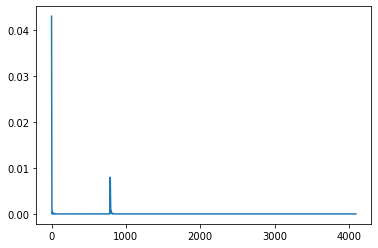

In [ ]:
hh = test.ka_hh[:,500]
plt.plot(hh)
m=np.amax(hh>-val)
print(m)

In [ ]:
diffs_list = []
for index in range(0, np.shape(test.ka_hh)[1]):
  #peaks_depths = test.ka_rg[argrelmax(test.ka_hh)]
  peaks, ranges = find_maxima(test.ka_hh[200:,index], test.ka_rg[200:,index])
  diff = peaks[0]-peaks[1]
  diffs_list.append(diff)

pearson correlation:  0.0010658214541184646


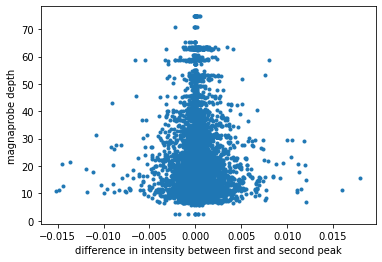

In [ ]:
a = np.asarray(diffs_list, dtype='float64')[ka_mask]

plt.plot(diffs_list, ka_ordered_df.DepthCm, '.')
plt.xlabel("difference in intensity between first and second peak")
plt.ylabel("magnaprobe depth")
print('pearson correlation: ', np.corrcoef(a, b[ka_mask])[0, 1])

pearson correlation:  -0.07278545578519084


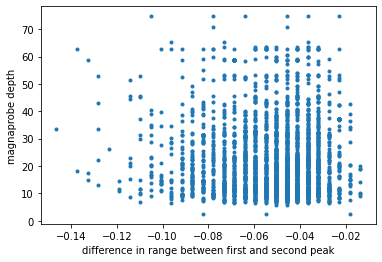

In [ ]:
diffs_list = []
for index in range(0, np.shape(test.ka_hh)[1]):
  #peaks_depths = test.ka_rg[argrelmax(test.ka_hh)]
  start, ranges = find_maxima(test.ka_hh[200:,index], test.ka_rg[200:,index])
  diff = ranges[0]-ranges[1]
  diffs_list.append(diff)
a = np.asarray(diffs_list, dtype='float64')
plt.plot(a[ka_mask], b[ka_mask], '.')
plt.xlabel("difference in range between first and second peak")
plt.ylabel("magnaprobe depth")
print('pearson correlation: ', np.corrcoef(a[ka_mask], b[ka_mask])[0, 1])

pearson correlation:  -0.08042307024300364


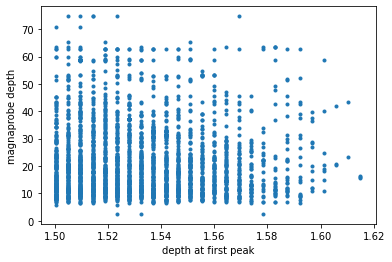

In [ ]:
firstmax_list = []
for index in range(0, np.shape(test.ka_hh)[1]):
  #peaks_depths = test.ka_rg[argrelmax(test.ka_hh)]
  start, ranges = find_maxima(test.ka_hh[200:,index], test.ka_rg[200:,index])
  firstmax = ranges[0]
  firstmax_list.append(firstmax)
a = np.asarray(firstmax_list, dtype='float64')
plt.plot(a[ka_mask], b[ka_mask], '.')
plt.xlabel("depth at first peak")
plt.ylabel("magnaprobe depth")
print('pearson correlation: ', np.corrcoef(a[ka_mask], b[ka_mask])[0, 1])

pearson correlation:  -0.014007535195848254


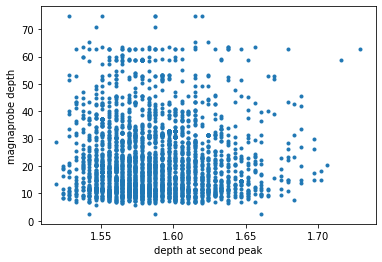

In [ ]:
secondmax_list = []
for index in range(0, np.shape(test.ka_hh)[1]):
  #peaks_depths = test.ka_rg[argrelmax(test.ka_hh)]
  start, ranges = find_maxima(test.ka_hh[200:,index], test.ka_rg[200:,index])
  secondmax = ranges[1]
  secondmax_list.append(secondmax)

a = np.asarray(secondmax_list, dtype='float64')

plt.plot(a[ka_mask], b[ka_mask], '.')
plt.xlabel("depth at second peak")
plt.ylabel("magnaprobe depth")
print('pearson correlation: ', np.corrcoef(a[ka_mask], b[ka_mask])[0, 1])

pearson correlation:  0.44149227217160025


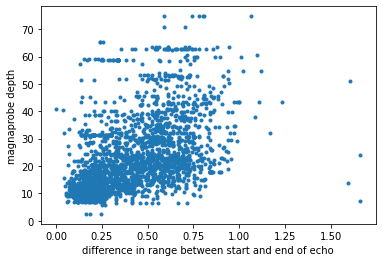

In [ ]:
widths_list = []
for index in range(0, np.shape(test.ka_hh)[1]):
  start, end = power_width(test.ka_hh[200:,index], test.ka_rg[200:,index])
  width = abs(start[1]-end[1]) #first element stores echo intensity second stores range val
  widths_list.append(width)
a = np.asarray(widths_list, dtype='float64')
plt.plot(a[ka_mask], b[ka_mask], '.')
plt.xlabel("difference in range between start and end of echo")
plt.ylabel("magnaprobe depth")
print('pearson correlation: ', np.corrcoef(a[ka_mask], b[ka_mask])[0, 1])

/usr/local/lib/python3.7/dist-packages/control/ctrlutil.py:122: RuntimeWarning: divide by zero encountered in log10
  return 20. * np.log10(mag)


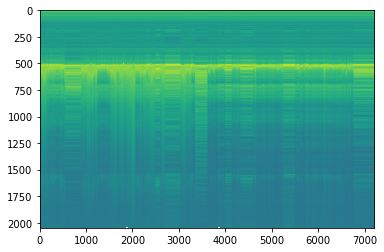

In [ ]:
plt.imshow(control.mag2db(test.ku_hh), aspect='auto',cmap='viridis')

Mean Squared Error is:  2.4612460242895568e-29


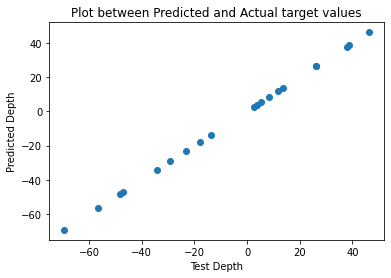

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics

#swap in the variables i actually want to use later for now generate these
X, y = datasets.make_regression(n_features=1, n_informative=1)

std = preprocessing.StandardScaler()

# X is a matrix
std.fit(X)
X_std = std.transform(X)

train_x, test_x, train_y, test_y = train_test_split(X_std,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

linreg = LinearRegression().fit(train_x, train_y)
pred_y = linreg.predict(test_x)
mse = metrics.mean_squared_error(test_y, pred_y)
print("Mean Squared Error is: ", mse)
plt.scatter(test_y, pred_y)
plt.xlabel('Test Depth')
plt.ylabel('Predicted Depth')
plt.title("Plot between Predicted and Actual target values")
plt.show()

In [ ]:
ku_firstmax_list = []
for index in range(0, np.shape(test.ku_hh)[1]):
  #peaks_depths = test.ka_rg[argrelmax(test.ka_hh)]
  start, ranges = find_maxima(test.ku_hh[200:,index], test.ku_rg[200:,index])
  firstmax = ranges[0]
  ku_firstmax_list.append(firstmax)

In [ ]:
#KU crosspol and copol use difference

#VH max
snowice_list_ku_vh = []
for index in range(0, np.shape(test.ku_vh)[1]):
  ind = np.argmax(test.ku_vh[200:,index])
  d = test.ku_rg[ind, index]
  snowice_list_ku_vh.append(d)

#HV max
snowice_list_ku_hv = []
for index in range(0, np.shape(test.ku_hv)[1]):
  ind = np.argmax(test.ku_hv[200:,index])
  d = test.ku_rg[ind, index]
  snowice_list_ku_hv.append(d)

#HH max
airsnow_list_ku_hh = []
for index in range(0, np.shape(test.ku_hh)[1]):
  ind = np.argmax(test.ku_hh[200:,index])
  d = test.ku_rg[ind, index]
  airsnow_list_ku_hh.append(d)

#VV max
airsnow_list_ku_vv = []
for index in range(0, np.shape(test.ku_vv)[1]):
  ind = np.argmax(test.ku_vv[200:,index])
  d = test.ku_rg[ind, index]
  airsnow_list_ku_vv.append(d)


#VH HH differences
ku_vhhh_snowdepths = []
for index in range(0, len(snowice_list_ku_vh)):
  d = (snowice_list_ku_vh[index] - airsnow_list_ku_hh[index])
  ku_vhhh_snowdepths.append(d)

#VH VV differences
ku_vhvv_snowdepths = []
for index in range(0, len(snowice_list_ku_vh)):
  d = (snowice_list_ku_vh[index] - airsnow_list_ku_vv[index])
  ku_vhvv_snowdepths.append(d)

#HV HH differences
ku_hvhh_snowdepths = []
for index in range(0, len(snowice_list_ku_hv)):
  d = (snowice_list_ku_hv[index] - airsnow_list_ku_hh[index])
  ku_hvhh_snowdepths.append(d)

#HV VV differences
ku_hvvv_snowdepths = []
for index in range(0, len(snowice_list_ku_hv)):
  d = (snowice_list_ku_hv[index] - airsnow_list_ku_vv[index])
  ku_hvvv_snowdepths.append(d)

ku_scaled_mag_depths = ku_ordered_df.DepthCm/0.8

Text(0, 0.5, 'magnaprobe snow depths scaled by 0.8')

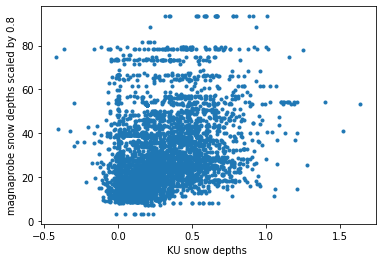

In [ ]:
plt.plot(ku_vhhh_snowdepths, ku_scaled_mag_depths, '.')
plt.xlabel('KU snow depths ')
plt.ylabel('magnaprobe snow depths scaled by 0.8')

Mean Squared Error is:  0.046383875122807


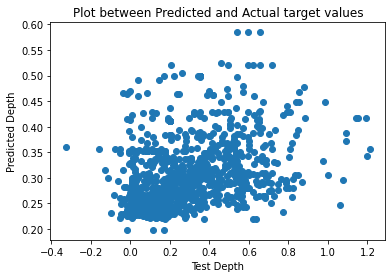

In [ ]:
#std = preprocessing.StandardScaler()

# X is a matrix
X = ku_scaled_mag_depths.values.reshape(-1, 1)
std.fit(X)
X_std = std.transform(X)

train_x, test_x, train_y, test_y = train_test_split(X_std,
                                                    ku_vhhh_snowdepths,
                                                    test_size=0.2,
                                                    random_state=42)

linreg = LinearRegression().fit(train_x, train_y)
pred_y = linreg.predict(test_x)
mse = metrics.mean_squared_error(test_y, pred_y)
print("Mean Squared Error is: ", mse)
plt.scatter(test_y, pred_y)
plt.xlabel('Test Depth')
plt.ylabel('Predicted Depth')
plt.title("Plot between Predicted and Actual target values")
plt.show()

In [ ]:
#KA crosspol and copol use difference

#VH max
snowice_list_ka_vh = []
for index in range(0, np.shape(test.ka_vh)[1]):
  ind = np.argmax(test.ka_vh[200:,index])
  d = test.ka_rg[ind, index]
  snowice_list_ka_vh.append(d)

#HV max
snowice_list_ka_hv = []
for index in range(0, np.shape(test.ka_hv)[1]):
  ind = np.argmax(test.ka_hv[200:,index])
  d = test.ka_rg[ind, index]
  snowice_list_ka_hv.append(d)

#HH max
airsnow_list_ka_hh = []
for index in range(0, np.shape(test.ka_hh)[1]):
  ind = np.argmax(test.ka_hh[200:,index])
  d = test.ka_rg[ind, index]
  airsnow_list_ka_hh.append(d)

#VV max
airsnow_list_ka_vv = []
for index in range(0, np.shape(test.ka_vv)[1]):
  ind = np.argmax(test.ka_vv[200:,index])
  d = test.ka_rg[ind, index]
  airsnow_list_ka_vv.append(d)

#VH HH differences
ka_vhhh_snowdepths = []
for index in range(0, len(snowice_list_ka_vh)):
  d = (snowice_list_ka_vh[index] - airsnow_list_ka_hh[index])
  ka_vhhh_snowdepths.append(d)

#VH VV differences
ka_vhvv_snowdepths = []
for index in range(0, len(snowice_list_ka_vh)):
  d = (snowice_list_ka_vh[index] - airsnow_list_ka_vv[index])
  ka_vhvv_snowdepths.append(d)

#HV HH differences
ka_hvhh_snowdepths = []
for index in range(0, len(snowice_list_ka_hv)):
  d = (snowice_list_ka_hv[index] - airsnow_list_ka_hh[index])
  ka_hvhh_snowdepths.append(d)

#HV VV differences
ka_hvvv_snowdepths = []
for index in range(0, len(snowice_list_ka_hv)):
  d = (snowice_list_ka_hv[index] - airsnow_list_ka_vv[index])
  ka_hvvv_snowdepths.append(d)

#scale magnaprobe depths by 0.8 to account for velocity change in snow
ka_scaled_mag_depths = ka_ordered_df.DepthCm/0.8

Text(0, 0.5, 'magnaprobe snow depths scaled by 0.8')

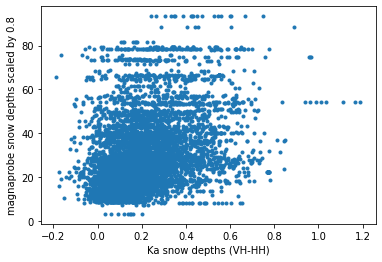

In [ ]:
plt.plot(ka_vhhh_snowdepths, ka_scaled_mag_depths, '.')
plt.xlabel('Ka snow depths (VH-HH)')
plt.ylabel('magnaprobe snow depths scaled by 0.8')

In [ ]:
#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'cm'
#plt.rcParams["font.size"] = 14

def BayesianLinearRegression(x,y,x_test,opt=True):
    
    def MLII(hyperparameters): #empirical Bayesian approach known as type-II maximum likelihood
        noise = np.exp(hyperparameters[0])
        try:
            K = mdot([x,Σ_prior,x.T]) + np.eye(n)*noise
            L = np.linalg.cholesky(K)
            α = np.atleast_2d(np.linalg.solve(L.T,np.linalg.solve(L,y_))).T
            nlZ = np.dot(y_.T,α)/2 + np.log(L.diagonal()).sum() + n*np.log(2*np.pi)/2 #Algorithm 2.1 R&W

            Q = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(n))) - np.dot(α,α.T)
            dnlZ = noise*np.trace(Q) 

        except (np.linalg.LinAlgError) as e:
            nlZ = np.inf ; dnlZ = np.inf
        return nlZ,dnlZ
    
    M = x.shape[1] #number of predictors

    #define the prior w ~ N(0,Σ_prior) eq 2.4 Rasmussen and Williams, 2006
    μ_prior = np.zeros(M) #zero mean prior 
    Σ_prior = np.eye(M)*100 #prior covariance matrix
    y_ = y - np.dot(x,μ_prior) #compute this here for convenience
    
    if opt:
        noise = np.exp(scipy.optimize.minimize(MLII,x0=np.log(.3),method='CG',jac=True).x)
    else:
        noise = .3

    K = mdot([x,Σ_prior,x.T]) + np.eye(n)*noise
    Kxs = mdot([x_test,Σ_prior,x_test.T])
    Kxxs = mdot([x,Σ_prior,x_test.T])
    
    L = np.linalg.cholesky(K)
    α = np.atleast_2d(np.linalg.solve(L.T,np.linalg.solve(L,y_))).T
    v = np.linalg.solve(L,Kxxs)

    return np.dot(x_test,μ_prior) + np.dot(Kxxs.T,α).ravel(), np.sqrt((Kxs - np.dot(v.T,v)).diagonal()) + noise

Mean Squared Error is:  0.030664437390810356


TypeError: ignored

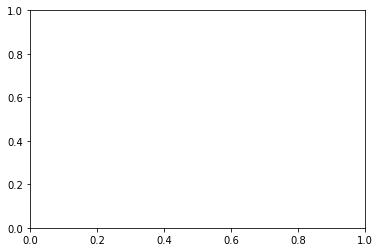

In [ ]:
#std = preprocessing.StandardScaler()

# X is a matrix
X = ka_scaled_mag_depths.values.reshape(-1, 1)
std.fit(X)
X_std = std.transform(X)

train_x, test_x, train_y, test_y = train_test_split(X_std,
                                                    ka_vhhh_snowdepths,
                                                    test_size=0.2,
                                                    random_state=42)

linreg = LinearRegression().fit(train_x, train_y)
pred_y = linreg.predict(test_x)
mse = metrics.mean_squared_error(test_y, pred_y)
print("Mean Squared Error is: ", mse)
plt.scatter(test_y, pred_y, 'k.', markersize=0.3)

#X, Y = np.meshgrid(test_y, pred_y)
#Z = np.sqrt(X**2 + Y**2)
#fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, Z)
#fig.colorbar(cp) # Add a colorbar to a plot
#ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
#ax.set_ylabel('y (cm)')
plt.show()
#plt.contour([test_y, pred_y,] Z, [levels], **kwargs)
plt.xlabel('Test Depth')
plt.ylabel('Predicted Depth')
plt.title("Plot between Predicted and Actual target values")
plt.show()

In [ ]:
np.random.seed(20)
n=5000
ns=len(ku_vhhh_snowdepths[n:])
x = np.asarray([np.ones(n),np.asarray(ku_vhhh_snowdepths[:n])]).T #training inputs
x_test = np.asarray([np.ones(ns),np.asarray(ku_vhhh_snowdepths[n:])]).T #test inputs
y = np.asarray(ku_scaled_mag_depths[:n].values,'float64') #training targets

#generate regression fit and uncertainty estimates
posterior,error = BayesianLinearRegression(x,y,x_test,opt=True)

x_test1, posterior, error = zip(*sorted(zip(x_test[:,1], posterior, error)))
x_test1 = np.array(x_test1)
posterior = np.array(posterior)
error = np.array(error)

fig,ax = plt.subplots(1,figsize=(12,5))
plt.scatter(x[:,1],y,color='k')
# plt.plot(x[:,1],w0_true + x[:,1]*w1_true,'midnightblue')
plt.plot(x_test1,posterior,color='crimson',linestyle='--')
plt.fill_between(x_test1,posterior+error,posterior-error,color='crimson',alpha=0.4)
# plt.xlim(-1.8,1.8)
# plt.ylim(-1.75,0.75)
plt.xlim(-0.5,1.8)
plt.show()